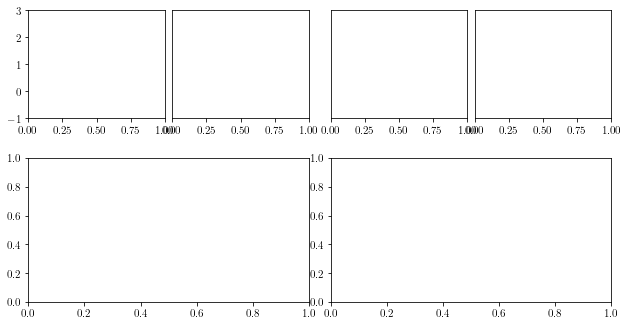

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
from numpy import savez
import math
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks

from matplotlib import rc
rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=True)
rc('font',**{'size':11,})
from matplotlib import figure
from matplotlib.gridspec import GridSpec
#Combining the Data for Z, U = 2, 4, 8

fig_combined = plt.figure()
ax_2_high_time = fig_combined.add_axes([0.1,0.61,0.19,0.3])
ax_2_low_time = fig_combined.add_axes([0.3,0.61,0.19,0.3], sharey=ax_2_high_time)
ax_2_FFT = fig_combined.add_axes([0.1,0.1,0.39,0.4])

ax_8_high_time = fig_combined.add_axes([0.52,0.61,0.19,0.3], sharey=ax_2_high_time)
ax_8_low_time = fig_combined.add_axes([0.72,0.61,0.19,0.3], sharey=ax_2_high_time)
ax_8_FFT = fig_combined.add_axes([0.52,0.10,0.39,0.4], sharey=ax_2_FFT)
FFT_ax_ratio = 2

ax_2_low_time.get_yaxis().set_visible(False)
ax_8_high_time.get_yaxis().set_visible(False)
ax_8_low_time.get_yaxis().set_visible(False)

ax_2_high_time.set_yticks([-1, 0, 1,2,3])
fig_combined.set_size_inches(10,5)

color1 = '#840F9C'
color2 = '#498AD8'
color3 = '#EC921B'


In [3]:
def ExtractTimeDomainData(folderTuple):
    returnList = []
    for file in folderTuple:
        for filename in os.listdir(file):
            if filename.endswith('.npz'):
                data = np.load(file + '\\'+filename)
                returnList.append(data)
    return returnList

def Gfunc(Uval,V_initial):
    Vstart = V_initial
    omega1 = 0.25*(np.sqrt(Uval**2 + 64*Vstart**2) - np.sqrt(Uval**2 + 16*Vstart**2))
    omega2 = 0.25*(np.sqrt(Uval**2 + 64*Vstart**2) + np.sqrt(Uval**2 + 16*Vstart**2))
    a1 = 0.5*(1 - (Uval**2 - 32*Vstart**2)/(np.sqrt(Uval**2 + 64*Vstart**2)*(Uval**2 + 16*Vstart**2)))
    a2 = 1 - a1
    def Gt(t):
        return (a1*np.cos(t*omega1) + a2*np.cos(t*omega2))

    return Gt, omega1, omega2

def Gfunc_phase(Uval,V_initial, phase):
    Vstart = V_initial
    omega1 = 0.25*(np.sqrt(Uval**2 + 64*Vstart**2) - np.sqrt(Uval**2 + 16*Vstart**2))
    omega2 = 0.25*(np.sqrt(Uval**2 + 64*Vstart**2) + np.sqrt(Uval**2 + 16*Vstart**2))
    a1 = 0.5*(1 - (Uval**2 - 32*Vstart**2)/(np.sqrt(Uval**2 + 64*Vstart**2)*(Uval**2 + 16*Vstart**2)))
    a2 = 1 - a1
    def Gt(t):
        return (a1*np.cos(t*omega1 + phase) + a2*np.cos(t*omega2 + phase))

    return Gt

def toHerz(w):
    return w/(2*np.pi)

def toRad(f):
    return f*(2*np.pi)

from scipy.optimize import minimize
def fitPhase(x, iG, times):
    phase = x[0]
    amp = x[1]
    Gt = Gfunc_phase(U, V, phase)
    return np.sum(abs(iG - amp*Gt(times)))


In [4]:
print(os.getcwd())
fileLocations = [('..\\data\\U2_manila\\U_2_V_0.9648812617448254_it_6_102521_403_F_1.604691818302353_v_1' , '..\\data\\U2_manila\\U_2_V_0.9648812617448254_it_6_102521_403_F_0.9404141739633851_v_1'), ('..\\data\\U4_manila\\U_4_V_0.7291692056987955_it_14_101721_587_F_5T30.0_v_4','..\\data\\U4_manila\\U_4_V_0.7291692056987955_it_14_101721_587_F_1T150_v_4'), ('..\\data\\U8_manila\\U_8_V_0.11880589992573226_it_8_101821_687_F_3.8197T39.2701_v_1','..\\data\\U8_manila\\U_8_V_0.11880589992573226_it_8_101821_687_F_0.0467T3211.9914_v_1')]
npz_list = []
for set in fileLocations:
    npz_list.append(ExtractTimeDomainData(set))

c:\Users\Thoma\OneDrive\Documents\2021_ORNL\paper_code\figures


0.9404141739633851 1.604691818302353
Low 0.08258394164884932, High 0.17068823222105423 Normalization:
[7.93359086 0.17068823]
Phases
1.5897510082956037
7.933590863151306


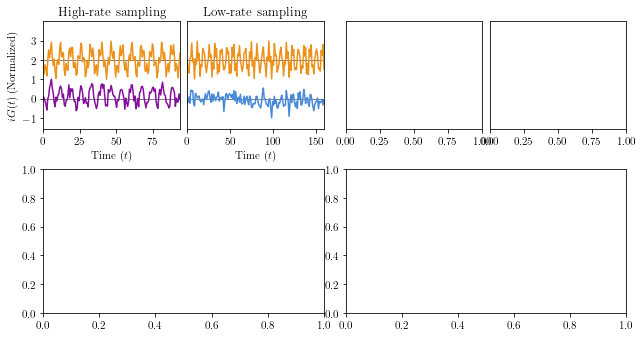

In [5]:
#U2:
U = 2
ax_2_high_time.clear()
ax_2_low_time.clear()
ax_2_high_time.clear()
timesLow = npz_list[0][1]['times']
timesHigh = npz_list[0][0]['times']
iGLow = npz_list[0][1]['iGreal']
iGHigh = npz_list[0][0]['iGreal']
fs1 = npz_list[0][1]['frequency']
fs2 = npz_list[0][0]['frequency']
print(fs1, fs2)
V = npz_list[0][0]['Vval']
y1 = abs(fftshift(fft(iGLow)))
y2 = abs(fftshift(fft(iGHigh)))

low_normalize =  max(abs(iGLow))#np.partition(iGLow.flatten(), -2)[-1] #max(abs(iGLow))
high_normalize = max(abs(iGHigh))# np.partition(iGHigh.flatten(), -2)[-1]
print('Low {}, High {} Normalization:'.format(low_normalize, high_normalize))
iGLow = iGLow/low_normalize
iGHigh = iGHigh/high_normalize 
timesExtended_low = np.linspace(timesLow[0],timesLow[-1],len(timesLow))
timesExtended_high = np.linspace(timesHigh[0],timesHigh[-1],len(timesHigh))

#low_normalize = max(abs(iGLow))
#high_normalize =  max(abs(iGHigh))

w1_phase = 0.1
w2_phase = 0.1

resultLow  = minimize(fitPhase, (w1_phase,low_normalize), args=(iGLow, timesExtended_low), bounds=[(-100,100), (low_normalize/2, low_normalize)]).x
phase_w1 = resultLow[0]
low_normalize = resultLow[1]
resultHigh = minimize(fitPhase, (w2_phase,high_normalize), args=(iGHigh, timesExtended_high), bounds=[(-100,100), (high_normalize/2, high_normalize)]).x
print(resultHigh)
phase_w2 = resultHigh[0]
high_normalize = resultHigh[1]

print('Phases')
print(phase_w1)
print(phase_w2)
Gt_Low = Gfunc_phase(U, V, phase_w1)
Gt_High = Gfunc_phase(U, V, phase_w2)
ax_2_low_time.plot(timesExtended_low, Gt_Low(timesExtended_low) + 2, color=color3, linestyle='-')
ax_2_high_time.plot(timesExtended_high, Gt_High(timesExtended_high) + 2, color=color3, linestyle='-')
ax_2_high_time.hlines(2, timesHigh[0], timesHigh[-1], color='k', linewidth=0.5)
ax_2_low_time.hlines(2, timesLow[0], timesLow[-1], color='k', linewidth=0.5)

#timesExtended_high = np.linspace(timesHigh[0],timesHigh[-1],len(timesHigh)*10)
#timesExtended_low = np.linspace(timesLow[0],timesLow[-1],len(timesLow)*10)

Gt, omega1, omega2 = Gfunc(U,V)
timesExtended = np.linspace(timesLow[0],timesLow[-1],len(timesLow)*100)
normalization = max(abs(iGLow))
ax_2_high_time.hlines(0, -1, timesHigh[-1]+1, color='black', linewidth=0.5, zorder=-1)
ax_2_low_time.hlines(0, -1, timesLow[-1]+1, color='black', linewidth=0.5, zorder=-1)
ax_2_high_time.set_ylim(-1.6,4)######################################
ax_2_low_time.set_xlim(0,timesLow[-1])
ax_2_high_time.set_xlim(0,timesHigh[-1])
#ax_2_low_time.plot(timesExtended, Gt(timesExtended)*normalization, color='orange',label='G(t), rescaled')
ax_2_low_time.plot(timesLow, iGLow, color=color2)#, label='Low Frequency Sampling')
ax_2_high_time.set_title(r'High-rate sampling')
ax_2_low_time.set_title(r'Low-rate sampling')

ax_2_high_time.set_xlabel(r'Time ($t$)')
ax_2_low_time.set_xlabel(r'Time ($t$)')
ax_2_high_time.set_ylabel(r'$iG(t)$ (Normalized)')


#ax_2_low_time.annotate(r'ibmq_manila', xy=(0.25,0.05), xycoords='axes fraction', color=color2)
#ax_2_low_time.annotate(r'Exact Results', xy=(0.45,0.92), xycoords='axes fraction', color='k')
ax_2_high_time.set_yticks([-1, 0, 1,2,3])

#ax_2_high_time.legend()
#normalization = max(abs(iGHigh))
#ax_2_high_time.plot(timesHigh, Gt(timesHigh)*normalization, color='orange', label='G(t), rescaled')
ax_2_high_time.plot(timesHigh, iGHigh, color=color1)#,label='High Frequency Sampling')
#ax_2_low_time.legend()
fig_combined


In [6]:


ax_2_FFT.clear()
timesLow = npz_list[0][1]['times']
timesHigh = npz_list[0][0]['times']
iGLow = npz_list[0][1]['iGreal']
iGHigh = npz_list[0][0]['iGreal']
fs1 = npz_list[0][1]['frequency']
fs2 = npz_list[0][0]['frequency']
print(fs1, fs2)

y1 = abs(y1)
y2 = abs(y2)
w1 = fftshift(fftfreq(len(timesLow), d=1/fs1)* 2*np.pi)
w2 = fftshift(fftfreq(len(timesHigh), d=1/fs2)* 2*np.pi)
#Throw out negative and 0:
y1 = y1[w1>=0]
y2 = y2[w2>=0]
w1 = w1[w1>=0]
w2 = w2[w2>=0]
y1[0] = 0
y2[0] = 0
#Normalize y1 and y2:
y1 = y1/max(abs(y1))
y2 = y2/max(abs(y2))





#Shift y1 up by 1:
y1 = y1 
highPerceived = abs(toHerz(omega2) - fs1*np.rint(toHerz(omega2)/fs1))
highPerceived = toRad(highPerceived)
print(highPerceived)
timesExtended = np.linspace(0, max(timesLow), len(timesLow), endpoint=True)
Ge = Gt(timesExtended)
ye = abs(fftshift(fft(Ge)))
we = fftshift(fftfreq(len(timesExtended), d=1/fs1)* 2*np.pi)
#Throw out negative and 0:
ye = ye[we>0]
we = we[we>0]
#Normalize ye:
ye = ye/max(abs(ye))
#ax_2_FFT.plot(we, ye, color='k', label='Low Frequency Sampling') #Used to check Alias
print('w2 max')
print(max(w2))

timesExtended2 = np.linspace(0, max(timesHigh), len(timesHigh), endpoint=True)
Ge2 = Gt(timesExtended2)
ye2 = abs(fftshift(fft(Ge2)))
we2 = fftshift(fftfreq(len(timesExtended2), d=1/fs2) * 2*np.pi)
#Throw out negative and 0:
ye2 = ye2[we2 > 0]
we2 = we2[we2 > 0]
#Normalize ye:
ye2 = ye2/max(abs(ye2))

ax_2_FFT.plot(we2, ye2, color=color3,zorder=-1)
inset = ax_2_FFT.inset_axes([0, 0.55, 0.586, 0.45])

#inset = ax_2_FFT.inset_axes([0, 0.55, 0.64, 0.45])

inset.set_xlim(0, max(w1))
print('w1_max')
print(max(w1))
inset.set_ylim(0, 1.3)
inset.set_xticks([0, 1, 2, max(w1)])
inset.set_yticklabels([0, 1])
inset.set_xticklabels(['', 1, 2,r'$ \ \ \ \ \ \omega_{\mathrm{nyquist}}$'])
inset.set_yticks([0, 1])
inset.spines['bottom'].set_color(color2)  # 'C0' the default blue color
inset.spines['top'].set_color(color2)
inset.spines['left'].set_color(color2)
inset.spines['right'].set_color(color2)
inset.xaxis.label.set_color(color2)
inset.yaxis.label.set_color(color2)

inset.tick_params(axis='x', colors=color2)
inset.tick_params(axis='y', colors=color2)
inset.plot(we, ye, color=color3, zorder=-1)


omega_1_computed = 0.906015466478226
omega_2_computed = 3.09198999029464
inset.plot(w1, abs(y1), color='#1e88e5ff')#, label='Low Frequency Sampling')
ax_2_FFT.plot(w2, abs(y2), color='purple')#, label='High Frequency Sampling')
#ax_2_FFT.vlines(max(w1), 0, 5, color='k', linestyles='dashed')

ax_2_FFT.set_ylim(0,2.5)
ax_2_FFT.set_yticklabels([])
#inset.vlines(omega1, 0, 1, color=color3, linestyles='solid', label=r'$\omega_{1,e}$:' + ' {}'.format(np.round(omega1,2)), zorder=-1)
#ax_2_FFT.vlines(omega2, 0, 1, color=color3, linestyles='solid', label=r'$\omega_{2,e}$:' + ' {}'.format(np.round(omega2,2)), zorder=-1)
#ax_2_FFT.legend()

inset.annotate(r'Alias $\omega\colon$ {alias}'.format(alias=np.round(highPerceived, 2)), xy=(highPerceived, max(y1[-20:])), textcoords='offset points', xytext=(25, 25*np.tan(np.deg2rad(30))), va='center', arrowprops=dict(facecolor='k', width=3, headwidth=7, headlength=7, linewidth=0))  # , shrink=0.01))
#ax_2_FFT.annotate(r'{alias}'.format(alias=np.round(highPerceived,4)), xy=(highPerceived, max(y1[-20:])), xytext=(highPerceived+0.8, 1.7))

inset.annotate(r'$\omega_1\colon$ {omegaNoisy}'.format(omegaNoisy=np.round(omega_1_computed, 2)), xy=(omega_1_computed, 1), textcoords='offset points', xytext=(25, 25*np.tan(np.deg2rad(-30))), va='center',  arrowprops=dict(width=3, headwidth=7, headlength=7, facecolor=color2, linewidth=0))  # , shrink=0.01))
ax_2_FFT.set_xlim(min(w2), max(w2))
# shrink=0.01))
ax_2_FFT.annotate(r'$\omega_2\colon$ {omegaNoisy}'.format(omegaNoisy=np.round(omega_2_computed, 2)), xy=(omega_2_computed, max(y2[30:120])), textcoords='offset points', xytext=(25, 25*np.tan(np.deg2rad(45))), va='center', arrowprops=dict(facecolor=color1, width=3, headwidth=7, headlength=7, linewidth=0))


0.9404141739633851 1.604691818302353
2.828574952543383
w2 max
4.974070853952262
w1_max
2.915006283451684


<ipython-input-6-5645b2f84960>:67: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset.set_yticklabels([0, 1])


Text(25, 24.999999999999996, '$\\omega_2\\colon$ 3.09')

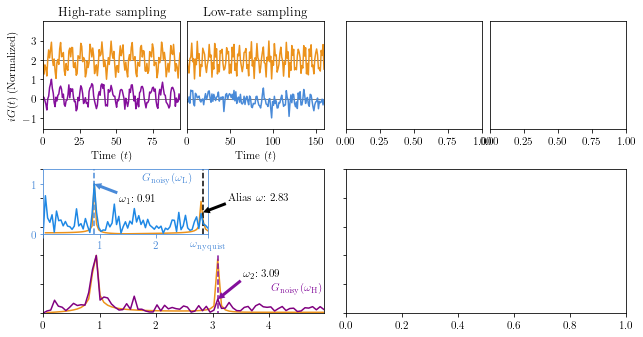

In [7]:

#ax_2_FFT.annotate(r'$G_{\mathrm{noisy}}(\omega_{\mathrm{L}})$', xy=(0.8,0.9), xycoords='axes fraction', color=color2)
inset.annotate(r'$G_{\mathrm{noisy}}(\omega_{\mathrm{L}})$', xy=(0.6,0.82), xycoords='axes fraction', color=color2)

ax_2_FFT.annotate(r'$G_{\mathrm{noisy}}(\omega_{\mathrm{H}})$', xy=(0.81,0.15), xycoords='axes fraction', color=color1)
inset.vlines(highPerceived, min(abs(y1)), 10, color='k', linestyles='dashed') #Alias Line
inset.vlines(omega_1_computed, 0, 10, color=color2, linestyles='dashed',zorder=1) #w1 Line
ax_2_FFT.vlines(omega_2_computed, -10, 1, color=color1, linestyles='dashed',zorder=1) #w2 Line

#ax_2_FFT.scatter(w2, abs(y2), color='purple',s=30)#, label='High Frequency Sampling')
fig_combined


0.0467 3.8197
0.0467 3.8197
Low 0.10234455790961197, High 0.08003809168393936 Normalization:
[-0.66692875  0.08003809]
Phases
97.6240909570575
-0.6669287500606487


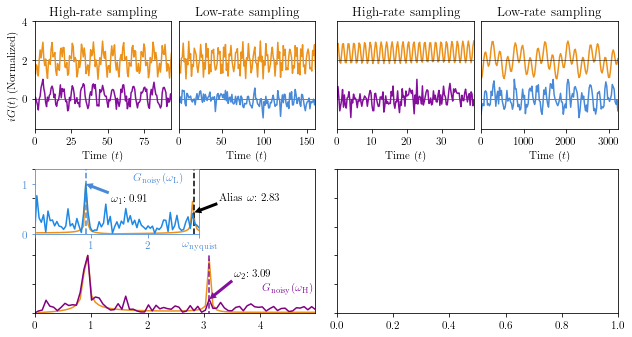

In [8]:
#U2:
U = 8
#ax_8_high_time.clear()
ax_8_low_time.clear()
ax_8_high_time.clear()
timesLow = npz_list[2][1]['times']
timesHigh = npz_list[2][0]['times']
iGLow = npz_list[2][1]['iGreal']
iGHigh = npz_list[2][0]['iGreal']
fs1 = npz_list[2][1]['frequency']
fs2 = npz_list[2][0]['frequency']
print(fs1, fs2)
print(fs1, fs2)
V = npz_list[2][0]['Vval']

y1 = abs(fftshift(fft(iGLow)))
y2 = abs(fftshift(fft(iGHigh)))

low_normalize =  max(abs(iGLow))#np.partition(iGLow.flatten(), -2)[-5] #max(abs(iGLow))
high_normalize = max(abs(iGHigh))#np.partition(iGHigh.flatten(), -2)[-5]
print('Low {}, High {} Normalization:'.format(low_normalize, high_normalize))

iGLow = iGLow/low_normalize #* 0.1
iGHigh = iGHigh/high_normalize# * 0.1
timesExtended_low = np.linspace(timesLow[0],timesLow[-1],len(timesLow))
timesExtended_high = np.linspace(timesHigh[0],timesHigh[-1],len(timesHigh))

#low_normalize = max(abs(iGLow))
#high_normalize =  max(abs(iGHigh))

w1_phase = 100
w2_phase = 0.1

resultLow  = minimize(fitPhase, (w1_phase,low_normalize), args=(iGLow, timesExtended_low), bounds=[(-100,100), (low_normalize/2, low_normalize)]).x
phase_w1 = resultLow[0]
low_normalize = resultLow[1]
resultHigh = minimize(fitPhase, (w2_phase,high_normalize), args=(iGHigh, timesExtended_high), bounds=[(-100,100), (high_normalize/2, high_normalize)]).x
print(resultHigh)
phase_w2 = resultHigh[0]
high_normalize = resultHigh[1]

print('Phases')
print(phase_w1)
print(phase_w2)
Gt_Low = Gfunc_phase(U, V, phase_w1)
Gt_High = Gfunc_phase(U, V, phase_w2)

ax_8_low_time.plot(timesExtended_low, Gt_Low(timesExtended_low) + 2, color=color3,zorder=-1)#, linestyle='dashed')

ax_8_high_time.plot(timesExtended_high, Gt_High(timesExtended_high) + 2, color=color3,zorder=-1)#, linestyle='dashed')
ax_8_high_time.hlines(2, timesHigh[0], timesHigh[-1], color='k', linewidth=0.5)
ax_8_low_time.hlines(2, timesLow[0], timesLow[-1], color='k', linewidth=0.5)


Gt, omega1, omega2 = Gfunc(U,V)
timesExtended = np.linspace(timesLow[0],timesLow[-1],len(timesLow)*100)
normalization = max(abs(iGLow))
ax_8_high_time.set_title(r'High-rate sampling')
ax_8_low_time.set_title(r'Low-rate sampling')
ax_8_high_time.set_xlabel(r'Time ($t$)')
ax_8_low_time.set_xlabel(r'Time ($t$)')


ax_8_high_time.hlines(0, -1, timesHigh[-1]+1, color='black', linewidth=0.5)
ax_8_low_time.hlines(0, -1, timesLow[-1]+1, color='black', linewidth=0.5)
ax_8_low_time.set_xlim(0,timesLow[-1])
ax_8_high_time.set_xlim(0,timesHigh[-1])

ax_8_low_time.plot(timesLow, iGLow, color=color2)#, label='Low Frequency Sampling')

ax_8_high_time.plot(timesHigh, iGHigh, color=color1)#,label='High Frequency Sampling')


fig_combined


In [9]:
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import find_peaks
ax_8_FFT.clear()
timesLow = npz_list[2][1]['times']
timesHigh = npz_list[2][0]['times']
iGLow = npz_list[2][1]['iGreal']
iGHigh = npz_list[2][0]['iGreal']
fs1 = npz_list[2][1]['frequency']
fs2 = npz_list[2][0]['frequency']
print(fs1, fs2)
y1 = abs(fftshift(fft(iGLow)))
y2 = abs(fftshift(fft(iGHigh)))
w1 = fftshift(fftfreq(len(timesLow), d=1/fs1)* 2*np.pi)
w2 = fftshift(fftfreq(len(timesHigh), d=1/fs2)* 2*np.pi)
#Throw out negative and 0:
y1 = y1[w1>=0]
y2 = y2[w2>=0]
w1 = w1[w1>=0]
w2 = w2[w2>=0]
y1[w1 == 0] = 0
y2[w2 == 0] = 0
#Normalize y1 and y2:
y1 = y1/max(abs(y1))
y2 = y2/max(abs(y2))
#Shift y1 up by 1:
y1 = y1

highPerceived = abs(toHerz(omega2) - fs1*np.rint(toHerz(omega2)/fs1))
highPerceived = toRad(highPerceived)
print(highPerceived)


#ax_8_FFT.plot(w1, abs(y1), color=color2, label='Low Frequency Sampling')
#ax_8_FFT.vlines(max(w1), 0, 5, color='k', linestyles='dashed')
ax_8_FFT.plot(w2, abs(y2), color=color1, label='High Frequency Sampling')
y1 = y1

timesExtended = np.linspace(0, max(timesLow), len(timesLow), endpoint=True)
Ge = Gt(timesExtended)
ye = abs(fftshift(fft(Ge)))
we = fftshift(fftfreq(len(timesExtended), d=1/fs1)* 2*np.pi)
#Throw out negative and 0:
ye = ye[we>0]
we = we[we>0]
#Normalize ye:
ye = ye/max(abs(ye))
highPerceived = we[17]


timesExtended2 = np.linspace(0, max(timesHigh), len(timesHigh), endpoint=True)
Ge2 = Gt(timesExtended2)
ye2 = abs(fftshift(fft(Ge2)))
we2 = fftshift(fftfreq(len(timesExtended2), d=1/fs2) * 2*np.pi)
#Throw out negative and 0:
ye2 = ye2[we2 > 0]
we2 = we2[we2 > 0]
#Normalize ye:
ye2 = ye2/max(abs(ye2))

omega_1_computed = 0.013785055549778567
omega_2_computed = 4.15997970575787

peaks = find_peaks(ye, height=0.5, distance=10)
print(peaks)
inset = ax_8_FFT.inset_axes([0, 0.55, 0.586, 0.45])
#inset = ax_8_FFT.inset_axes([0, 0.55, 0.64, 0.45])

inset.set_xlim(0,max(w1))
inset.set_ylim(0,1.3)
inset.set_xticks([0,0.05,0.1,max(w1)])
inset.set_yticklabels([0,1])
inset.set_xticklabels(['',0.05, 0.1,r'$ \ \ \ \ \ \omega_{\mathrm{nyquist}}$'])
inset.set_yticks([0,1])
inset.plot(we, ye, color=color3)

inset.spines['bottom'].set_color(color2)  # 'C0' the default blue color
inset.spines['top'].set_color(color2)
inset.spines['left'].set_color(color2)
inset.spines['right'].set_color(color2)
inset.xaxis.label.set_color(color2)
inset.yaxis.label.set_color(color2)

inset.tick_params(axis='x', colors=color2)
inset.tick_params(axis='y', colors=color2)


#inset.scatter(w2, abs(y2), color=color1,s=30)#, label='High Frequency Sampling')
#inset.plot(we, ye, color='black')
inset.plot(w1, abs(y1), color='#1e88e5ff', label='Low Frequency Sampling')
#inset.vlines(omega1, 0, 1, color=color3, linestyles='solid')

inset.annotate('Alias $\omega\colon$ {}'.format(np.round(highPerceived, 2)), xy=(highPerceived, max(abs(y1))), textcoords='offset points', xytext=(
    25, 25*np.tan(np.deg2rad(0))), va='center', arrowprops=dict(facecolor='k', width=3, headwidth=7, headlength=7, linewidth=0))  # shrink=0.01))
inset.annotate(r'$\omega_1\colon$ {}'.format(np.round(omega_1_computed, 2)), xy=(omega_1_computed, max(y1[0:15])), textcoords='offset points', xytext=(
    50, 50*np.tan(np.deg2rad(0))), va='center', arrowprops=dict(facecolor=color2, width=3, headwidth=7, headlength=7, linewidth=0))  # shrink=0.01))
ax_8_FFT.set_ylim(0,2.5)
ax_8_FFT.set_yticklabels([0,1,''])
ax_2_FFT.set_ylabel(r'$|G(\omega)|$ (Normalized)')
ax_8_FFT.set_yticks([0,1])
#ax_8_FFT.vlines(omega1, 0, 1, color=color3, linestyles='solid')
#ax_8_FFT.vlines(omega2, 0, 1, color=color3, linestyles='solid')
ax_8_FFT.set_xlim(min(w2), max(w2))
ax_8_FFT.plot(we2,ye2,color=color3,zorder=-1)
ax_8_FFT.annotate(r'$\omega_2\colon$ {omegaNoisy}'.format(omegaNoisy=np.round(omega_2_computed, 2)), xy=(omega_2_computed, max(y2)), textcoords='offset points', xytext=(
    25, 25*np.tan(np.deg2rad(-30))), va='center', arrowprops=dict(facecolor=color1, width=3, headwidth=7, headlength=7, linewidth=0))  # shrink=0.01))
plt.setp(ax_8_FFT.get_xticklabels(),visible=True)

#ax_2_FFT.scatter(w2, abs(y2), color='purple',s=30)#, label='High Frequency Sampling')


0.0467 3.8197
0.09035556773216406
(array([ 4, 17], dtype=int64), {'peak_heights': array([0.68136805, 1.        ])})


<ipython-input-9-1bfce14d50c9>:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  inset.set_yticklabels([0,1])
<ipython-input-9-1bfce14d50c9>:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_8_FFT.set_yticklabels([0,1,''])


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

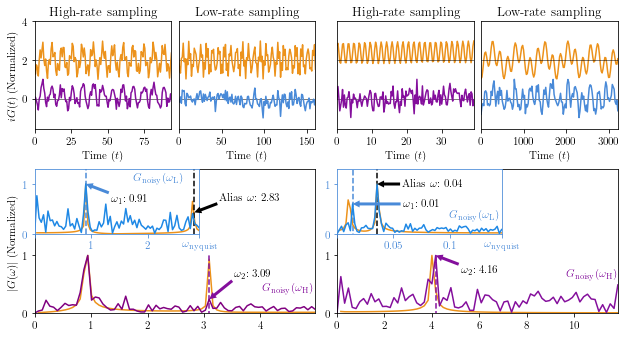

In [10]:
inset.annotate(r'$G_{\mathrm{noisy}}(\omega_{\mathrm{L}})$', xy=(0.68,0.25), xycoords='axes fraction', color=color2)

ax_8_FFT.annotate(r'$G_{\mathrm{noisy}}(\omega_{\mathrm{H}})$', xy=(0.815,0.25), xycoords='axes fraction', color=color1)
inset.vlines(highPerceived, min(abs(y1)), 10, color='k', linestyles='dashed') #Alias Line
inset.vlines(omega_1_computed, -10, 10, color=color2, linestyles='dashed',zorder=1) #w1 Line
ax_8_FFT.vlines(omega_2_computed, -10, 1, color=color1, linestyles='dashed',zorder=1) #w2 Line
fig_combined

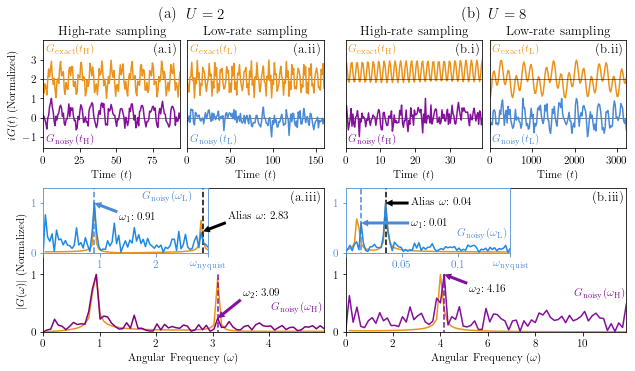

In [11]:
ax_8_FFT.set_xlabel(r'Angular Frequency ($\omega$)')
ax_2_FFT.set_xlabel(r'Angular Frequency ($\omega$)')
#ax_8_high_time.annotate(r'$U = 8$', xy=(0.93, 1.05), xycoords='axes fraction')
ax_2_high_time.set_yticks([-1, 0, 1,2,3])
ax_2_high_time.annotate(r'(a)', xy=(0.85, 1.21), xycoords='axes fraction', size=15)
ax_2_high_time.annotate(r'$U = 2$', xy=(1.05, 1.2), xycoords='axes fraction',size=15)

ax_8_high_time.annotate(r'(b)', xy=(0.85, 1.21), xycoords='axes fraction', size=15)
ax_8_high_time.annotate(r'$U = 8$', xy=(1.05, 1.2),                        xycoords='axes fraction', size=15)


ax_8_high_time.text(0.98, 0.973, r'(b.i)',
                    transform=ax_8_high_time.transAxes, va='top', ha='right', size=13)  # , color=color1)
ax_8_low_time.text(0.98, 0.973, r'(b.ii)',
                   transform=ax_8_low_time.transAxes, va='top', ha='right', size=13)#, color=color3)
ax_2_high_time.text(0.98, 0.973, r'(a.i)',
                    transform=ax_2_high_time.transAxes, va='top', ha='right', size=13)  # , color=color1)
ax_2_low_time.text(0.98, 0.973, r'(a.ii)',
                   transform=ax_2_low_time.transAxes, va='top', ha='right', size=13)  # , color=color3)


#ax_8_high_time.text(r'(b.i)', xy=(0.03, 0.9), xycoords='axes fraction', size=12)
#ax_8_low_time.text(r'(b.ii)', xy=(0.03, 0.9), xycoords='axes fraction', size=12)    
#ax_2_high_time.text(r'(a.i)', xy=(0.03, 0.9), xycoords='axes fraction', size=12)
#ax_2_low_time.text(r'(a.ii)', xy=(0.03, 0.9),
#                   xycoords='axes fraction', size=12)
from matplotlib.pyplot import Rectangle
#inset.add_patch(Rectangle((0,2), 1, 0.5, fill=True, color='white', linewidth=0, zorder=2))#, zorder=1)
ax_2_FFT.text(0.99, 0.98, r'(a.iii)', transform=ax_2_FFT.transAxes, va='top', ha='right', size=13)
ax_8_FFT.text(0.99, 0.98,r'(b.iii)' , transform=ax_8_FFT.transAxes, va='top', ha='right', size=13)

#ax_2_FFT.annotate(r'(a.iii)', xy=(0.02, 0.9), xycoords='axes fraction', size=13)

#ax_8_high_time.annotate(r'$G_{\mathrm{noisy}}(t_{\mathrm{H}})$', xy=(0.6,0.05), xycoords='axes fraction', color=color1)
#ax_8_high_time.annotate(r'$G_{\mathrm{exact}}(t_{\mathrm{H}})$', xy=(0.55,0.87), xycoords='axes fraction', color=color3)
#ax_8_low_time.annotate(r'$G_{\mathrm{exact}}(t_{\mathrm{L}})$', xy=(0.55,0.87), xycoords='axes fraction', color=color3)
#ax_8_low_time.annotate(r'$G_{\mathrm{noisy}}(t_{\mathrm{L}})$', xy=(0.03,0.05), xycoords='axes fraction', color=color2)

ax_8_high_time.text(0.02, 0.0266, r'$G_{\mathrm{noisy}}(t_{\mathrm{H}})$',
                    transform=ax_8_high_time.transAxes, va='bottom', ha='left', color=color1)
ax_8_high_time.text(0.02, 0.973, r'$G_{\mathrm{exact}}(t_{\mathrm{H}})$',
                    transform=ax_8_high_time.transAxes, va='top', ha='left', color=color3)
ax_8_low_time.text(0.02, 0.973, r'$G_{\mathrm{exact}}(t_{\mathrm{L}})$',
                   transform=ax_8_low_time.transAxes, va='top', ha='left', color=color3)
ax_8_low_time.text(0.02, 0.0266, r'$G_{\mathrm{noisy}}(t_{\mathrm{L}})$',
                   transform=ax_8_low_time.transAxes, va='bottom', ha='left', color=color2)


#ax_2_high_time.annotate(r'$G_{\mathrm{noisy}}(t_{\mathrm{H}})$', xy=(0.01,0.05), xycoords='axes fraction', color=color1)
#ax_2_high_time.annotate(r'$G_{\mathrm{exact}}(t_{\mathrm{H}})$', xy=(0.12,0.87), xycoords='axes fraction', color=color3)
#ax_2_low_time.annotate(r'$G_{\mathrm{exact}}(t_{\mathrm{L}})$', xy=(0.55,0.87), xycoords='axes fraction', color=color3)
#ax_2_low_time.annotate(r'$G_{\mathrm{noisy}}(t_{\mathrm{L}})$', xy=(0.03,0.05), xycoords='axes fraction', color=color2)


ax_2_high_time.text(0.02, 0.0266, r'$G_{\mathrm{noisy}}(t_{\mathrm{H}})$',
                    transform=ax_2_high_time.transAxes, va='bottom', ha='left', color=color1)
ax_2_high_time.text(0.02, 0.973, r'$G_{\mathrm{exact}}(t_{\mathrm{H}})$',
                    transform=ax_2_high_time.transAxes, va='top', ha='left', color=color3)
ax_2_low_time.text(0.02, 0.973, r'$G_{\mathrm{exact}}(t_{\mathrm{L}})$',
                   transform=ax_2_low_time.transAxes, va='top', ha='left', color=color3)
ax_2_low_time.text(0.02, 0.026, r'$G_{\mathrm{noisy}}(t_{\mathrm{L}})$',
                   transform=ax_2_low_time.transAxes, va='bottom', ha='left', color=color2)
fig_combined


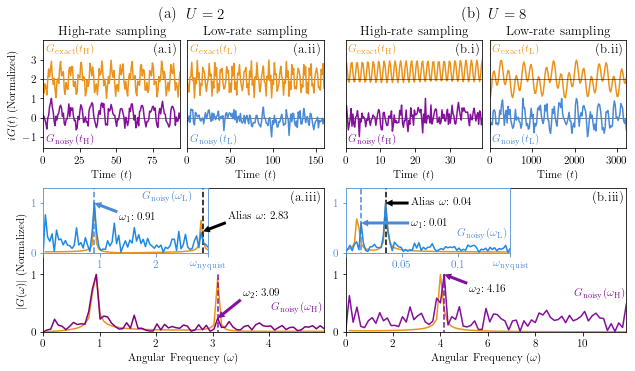

In [12]:
name = "Figure_4_final"
fig_combined.savefig('{}.png'.format(name), dpi=600)
fig_combined.savefig('{}.pdf'.format(name), dpi=600)
fig_combined.savefig('{}.svg'.format(name), dpi=600)
fig_combined
